In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import * 
from tensorflow.keras.applications.vgg19 import VGG19
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
print(len(tf.config.list_physical_devices('GPU')))

1


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/project

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/project


In [ ]:
import subprocess
from tqdm import tqdm


cmd = ['unzip', 'mstar.zip', '-d', '/content/sample_data']

with subprocess.Popen(cmd, stdout=subprocess.PIPE, bufsize=1, universal_newlines=True) as p, \
tqdm(total=100) as pbar:
    for line in p.stdout:
        pbar.update(1)

9467it [00:06, 1410.00it/s]


In [ ]:
#!unzip mstar.zip -d "/content/sample_data"

In [ ]:
image_size = (128,128)
batch_size = 32

In [ ]:
train_ds = image_dataset_from_directory('/content/sample_data/Padded_imgs',
                                           subset='training',
                                           image_size=image_size,
                                           labels='inferred',
                                           validation_split=.2,
                                           seed=10,
                                           label_mode='categorical',
                                           color_mode='grayscale',
                                           batch_size=batch_size)

val_ds = image_dataset_from_directory('/content/sample_data/Padded_imgs',
                                           subset='validation',
                                           image_size=image_size,
                                           labels='inferred',
                                           validation_split=.2,
                                           seed=10,
                                           label_mode='categorical',
                                           color_mode='grayscale',
                                           batch_size=batch_size)

Found 9466 files belonging to 8 classes.
Using 7573 files for training.
Found 9466 files belonging to 8 classes.
Using 1893 files for validation.


In [ ]:
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          "figure.figsize" : (10,10),
          "axes.titlecolor" : 'w',
          "axes.facecolor" : 'w',
          "figure.facecolor" : 'k'}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

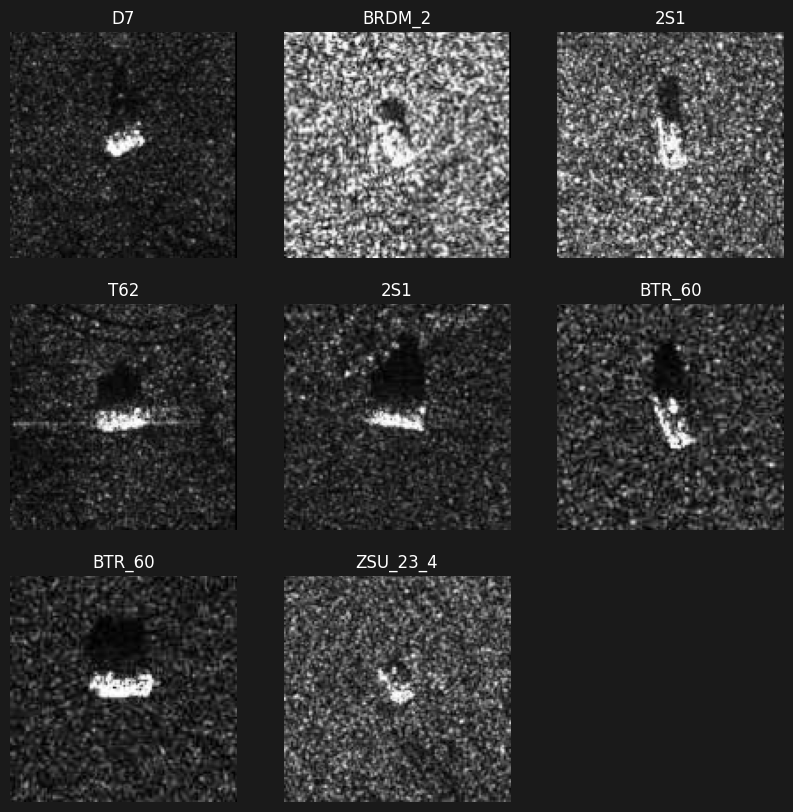

In [ ]:
class_names = train_ds.class_names
with plt.rc_context(params):
  plt.figure(figsize=(10, 10))
  for images, labels in train_ds.take(1):
    for i in range(8):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
      plt.title(class_names[np.argmax(labels[i])], )
      plt.axis("off")

In [ ]:
class_names

['2S1', 'BRDM_2', 'BTR_60', 'D7', 'SLICY', 'T62', 'ZIL131', 'ZSU_23_4']

In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 48
Number of test batches: 12


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Metrics 

In [ ]:
num_classes=8

metrics = [
      keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      tfa.metrics.MatthewsCorrelationCoefficient(num_classes=8, name='MCC'),
      tfa.metrics.FBetaScore(num_classes=8, average='weighted', beta=2.0, name='F2'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),
]

In [ ]:
def plot_metrics(history):
  with plt.rc_context(params):    
    metrics = ['loss', 'prc', 'F2', 'MCC']
    plt.figure(figsize=(10,10))
    for n, metric in enumerate(metrics):
      name = metric.replace("_"," ").capitalize()
      plt.subplot(2,2,n+1)
      plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
      plt.plot(history.epoch, history.history['val_'+metric],
              color=colors[0], linestyle="--", label='Val')
      plt.xlabel('Epoch')
      plt.ylabel(name)
      if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
      elif metric == 'auc':
        plt.ylim([0.8,1])
      elif metric == 'MCC':
        plt.ylim([-1,1])
      else:
        plt.ylim([0,1])

      plt.legend();

In [ ]:
def plot_cm(model, data):
    with plt.rc_context(params):
        y_true = []
        y_pred = []
        for x,y in data:
            y= tf.argmax(y,axis=1)
            y_true.append(y)
            y_pred.append(tf.argmax(model.predict(x),axis = 1))
    
        y_pred = tf.concat(y_pred, axis=0)
        y_true = tf.concat(y_true, axis=0)

        cm = confusion_matrix(y_true, y_pred)
        fig = plt.figure(figsize = (10,10))
        ax1 = fig.add_subplot(1,1,1)
        sns.set(font_scale=1.4) #for label size
        sns.heatmap(cm,cmap='binary', annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 10},
            cbar = False);
        ax1.set_ylabel('True Values',fontsize=14)
        ax1.set_xlabel('Predicted Values',fontsize=14)
        plt.show()

In [ ]:
def holdout_results(model):
    result = model.evaluate(test_ds)
    return dict(zip(model.metrics_names, result))

Model1

In [ ]:
model1 = keras.Sequential()

model1.add(InputLayer(input_shape=(image_size + (1,))))

model1.add(Flatten())

model1.add(Dense(100, activation='relu'))
model1.add(Dense(100, activation='relu'))
model1.add(Dense(100, activation='relu'))

model1.add(Dense(num_classes, activation='softmax'))

model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 16384)             0         
                                                                 
 dense_16 (Dense)            (None, 100)               1638500   
                                                                 
 dense_17 (Dense)            (None, 100)               10100     
                                                                 
 dense_18 (Dense)            (None, 100)               10100     
                                                                 
 dense_19 (Dense)            (None, 8)                 808       
                                                                 
Total params: 1,659,508
Trainable params: 1,659,508
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=metrics)
  
history1 = model1.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
237/237 [==============================] - 12s 15ms/step - loss: 49.0521 - categorical_accuracy: 0.5541 - MCC: 0.4870 - F2: 0.5531 - auc: 0.7846 - prc: 0.4524 - val_loss: 2.6249 - val_categorical_accuracy: 0.7164 - val_MCC: 0.6868 - val_F2: 0.6986 - val_auc: 0.8945 - val_prc: 0.6890
Epoch 2/10
237/237 [==============================] - 2s 7ms/step - loss: 1.9449 - categorical_accuracy: 0.8118 - MCC: 0.7835 - F2: 0.8115 - auc: 0.9316 - prc: 0.8001 - val_loss: 0.2895 - val_categorical_accuracy: 0.9304 - val_MCC: 0.9205 - val_F2: 0.9299 - val_auc: 0.9891 - val_prc: 0.9635
Epoch 3/10
237/237 [==============================] - 2s 7ms/step - loss: 0.8224 - categorical_accuracy: 0.8859 - MCC: 0.8687 - F2: 0.8858 - auc: 0.9688 - prc: 0.9043 - val_loss: 0.6275 - val_categorical_accuracy: 0.9119 - val_MCC: 0.9008 - val_F2: 0.9098 - val_auc: 0.9747 - val_prc: 0.9253
Epoch 4/10
237/237 [==============================] - 2s 7ms/step - loss: 1.3445 - categorical_accuracy: 0.8669 - MCC: 0.

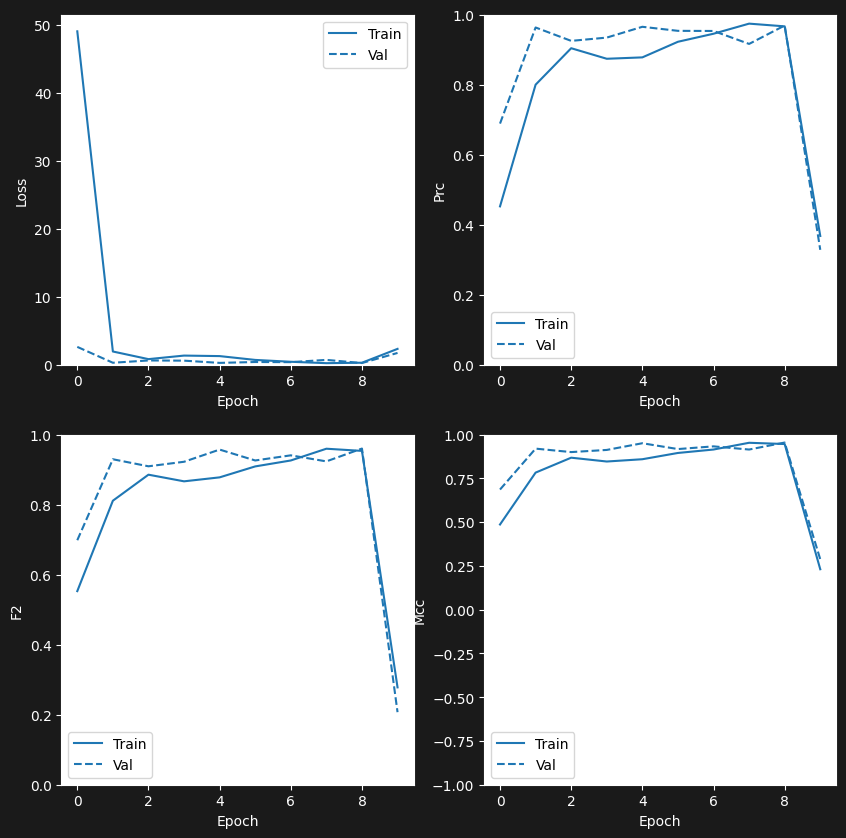

In [ ]:
plot_metrics(history1)

1/1 [==============================] - 0s 62ms/step


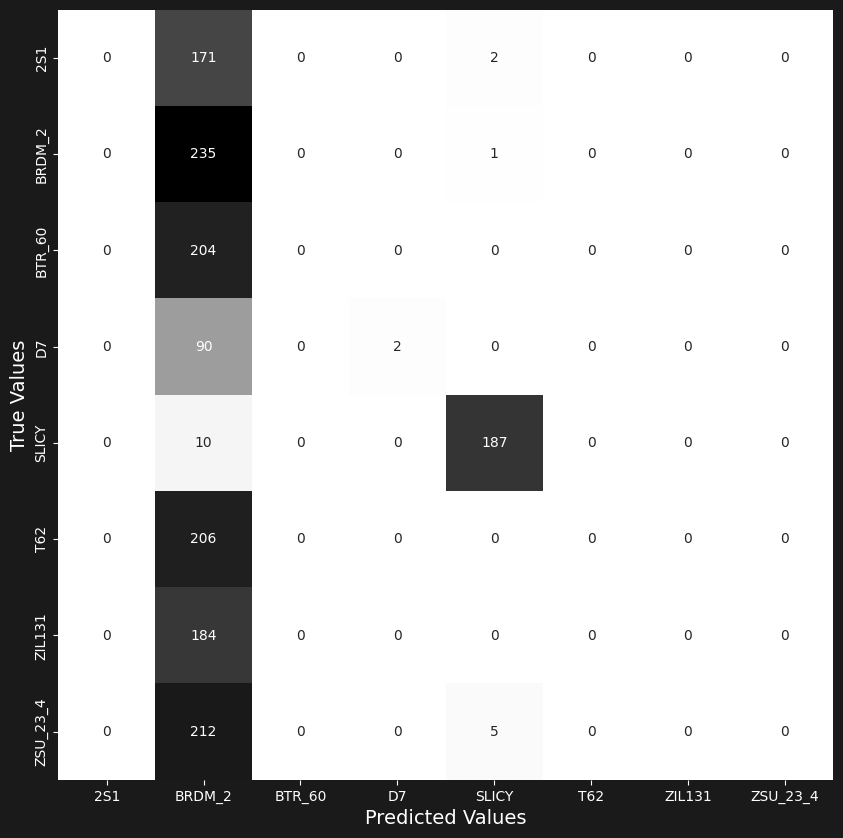

In [ ]:
plot_cm(model1, val_ds)

Model 2

In [ ]:
model2 = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(image_size + (1,))),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 32)       

In [ ]:
model2.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=metrics)

history2 = model2.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
237/237 [==============================] - 6s 16ms/step - loss: 0.7643 - categorical_accuracy: 0.6558 - MCC: 0.6081 - F2: 0.6500 - auc: 0.9347 - prc: 0.7785 - val_loss: 0.1025 - val_categorical_accuracy: 0.9808 - val_MCC: 0.9779 - val_F2: 0.9808 - val_auc: 0.9997 - val_prc: 0.9979
Epoch 2/10
237/237 [==============================] - 4s 16ms/step - loss: 0.1333 - categorical_accuracy: 0.9653 - MCC: 0.9600 - F2: 0.9653 - auc: 0.9978 - prc: 0.9905 - val_loss: 0.0810 - val_categorical_accuracy: 0.9848 - val_MCC: 0.9825 - val_F2: 0.9847 - val_auc: 0.9995 - val_prc: 0.9969
Epoch 3/10
237/237 [==============================] - 3s 14ms/step - loss: 0.0335 - categorical_accuracy: 0.9929 - MCC: 0.9918 - F2: 0.9929 - auc: 0.9996 - prc: 0.9988 - val_loss: 0.0787 - val_categorical_accuracy: 0.9755 - val_MCC: 0.9721 - val_F2: 0.9752 - val_auc: 0.9996 - val_prc: 0.9975
Epoch 4/10
237/237 [==============================] - 3s 13ms/step - loss: 0.0168 - categorical_accuracy: 0.9962 - MCC: 0

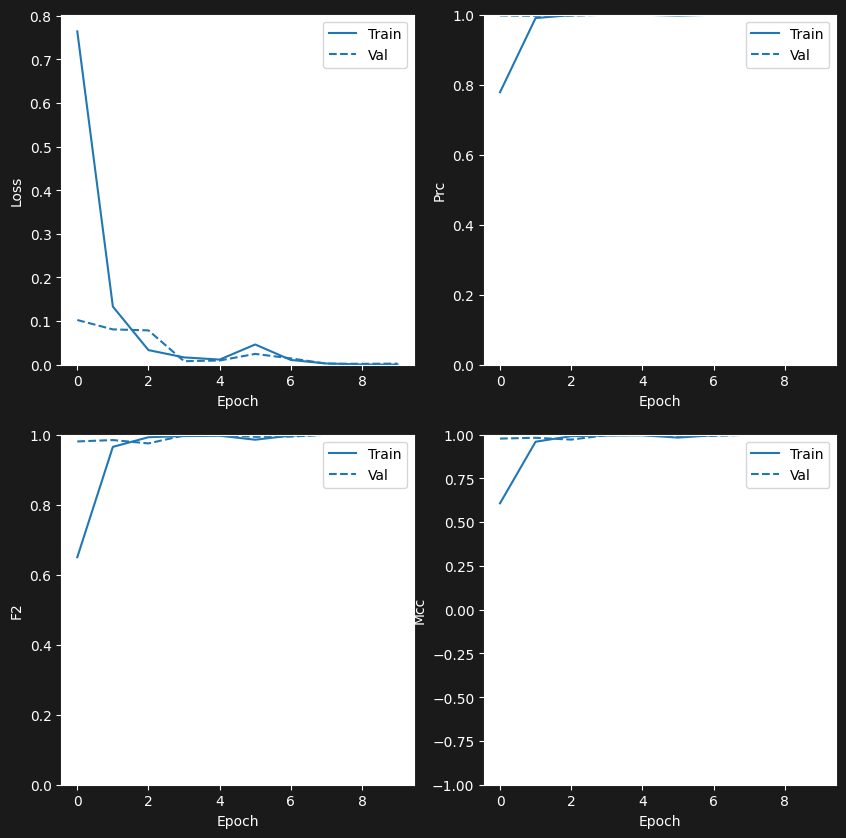

In [ ]:
plot_metrics(history2)

1/1 [==============================] - 0s 74ms/step


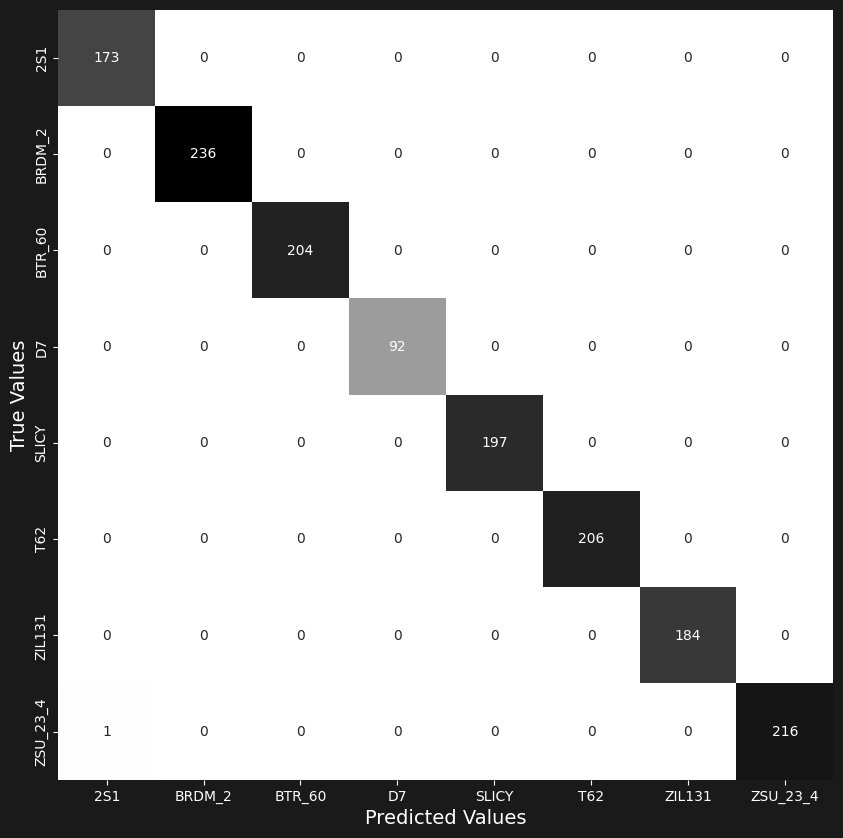

In [ ]:
plot_cm(model2, val_ds)

Tuning : Model 3

In [ ]:
callbacks=[
        keras.callbacks.EarlyStopping(patience=10, verbose=1, monitor='val_F2', mode='max', restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1)
        ]
 
last_model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(image_size + (1,))),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.Conv2D(128, 5, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 4, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 2, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

last_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=metrics,)

last_model_hist = last_model.fit(
    train_ds, epochs=100, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/100
237/237 [==============================] - 14s 46ms/step - loss: 1.4330 - categorical_accuracy: 0.5317 - MCC: 0.4603 - F2: 0.5246 - auc: 0.8899 - prc: 0.6449 - val_loss: 0.9022 - val_categorical_accuracy: 0.6779 - val_MCC: 0.6354 - val_F2: 0.6651 - val_auc: 0.9534 - val_prc: 0.7734 - lr: 0.0010
Epoch 2/100
237/237 [==============================] - 11s 45ms/step - loss: 0.9240 - categorical_accuracy: 0.6605 - MCC: 0.6091 - F2: 0.6586 - auc: 0.9390 - prc: 0.7479 - val_loss: 0.4694 - val_categorical_accuracy: 0.8231 - val_MCC: 0.7982 - val_F2: 0.8202 - val_auc: 0.9847 - val_prc: 0.9153 - lr: 0.0010
Epoch 3/100
237/237 [==============================] - 10s 43ms/step - loss: 0.6733 - categorical_accuracy: 0.7607 - MCC: 0.7248 - F2: 0.7600 - auc: 0.9666 - prc: 0.8452 - val_loss: 0.4731 - val_categorical_accuracy: 0.8363 - val_MCC: 0.8137 - val_F2: 0.8356 - val_auc: 0.9864 - val_prc: 0.9256 - lr: 0.0010
Epoch 4/100
237/237 [==============================] - 10s 43ms/step - loss:

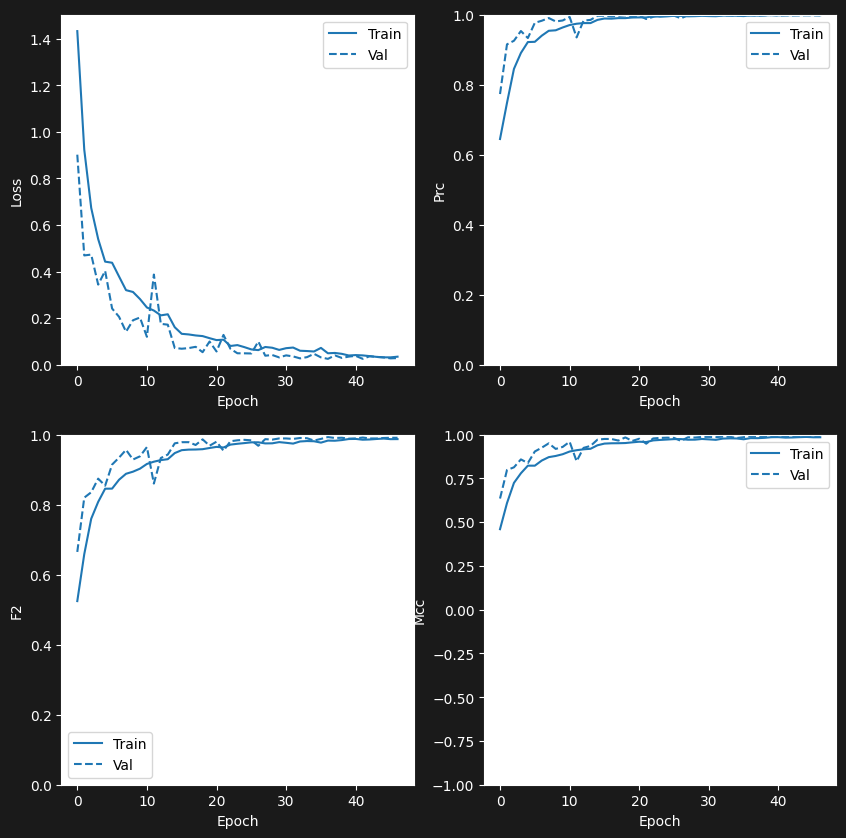

In [ ]:
plot_metrics(last_model_hist)

1/1 [==============================] - 0s 146ms/step


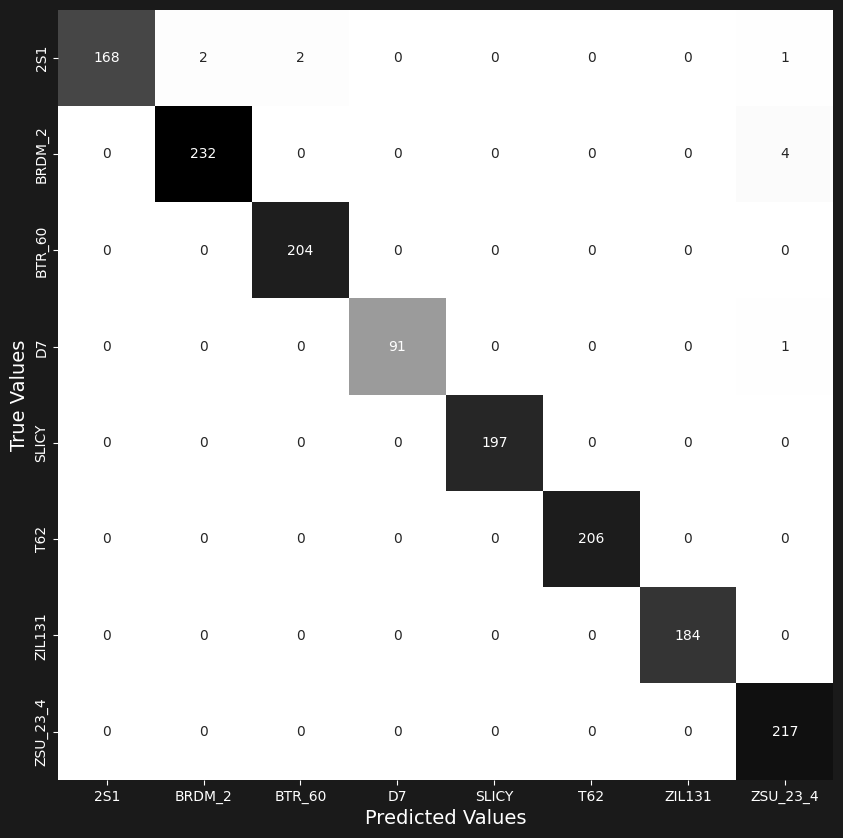

In [ ]:
plot_cm(last_model,val_ds)

In [ ]:
holdout_results(last_model)

12/12 [==============================] - 1s 53ms/step - loss: 0.0153 - categorical_accuracy: 0.9948 - MCC: 0.9940 - F2: 0.9948 - auc: 1.0000 - prc: 0.9999


{'loss': 0.01525410171598196,
 'categorical_accuracy': 0.9947916865348816,
 'MCC': 0.9940198063850403,
 'F2': 0.9947798252105713,
 'auc': 0.9999893307685852,
 'prc': 0.9999257326126099}

In [ ]:
def predict(model,img):
  image = keras.utils.load_img(
    path=img,
    color_mode='grayscale',
    target_size=(128,128))
  image_array = keras.utils.img_to_array(image)
  image_array = tf.expand_dims(image_array, 0)
  predictions=model.predict(image_array)
  score = tf.nn.softmax(predictions[0])
  return("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 300 * np.max(score)))

In [ ]:
predict(last_model,"/content/sample_data/Padded_imgs/2S1/HB15282.JPG")

1/1 [==============================] - 0s 30ms/step


'This image most likely belongs to 2S1 with a 83.90 percent confidence.'

In [ ]:
last_model.save("/content/sample_data/sartank_model.h5")